### Introduction

The data was collected during a period of 7 months, from 05.2019 until 12.2019, by means of a home-made system attached at approx. 25m above street level, in Bucharest.

The particle senzor used is a [Laser PM2.5 Sensor--SDS011 from Shandong Nova Fitness Co.,Ltd.](http://www.inovafitness.com/en/a/chanpinzhongxin/95.html).
The humidity and temperature senzor is a [DHT22 from Aosong Electronics co., Ltd.](https://www.sparkfun.com/datasheets/Sensors/Temperature/DHT22.pdf)

The system was constructed based on these [instructions](https://luftdaten.info/en/construction-manual/)

More on particulates measured [here](https://en.wikipedia.org/wiki/Particulates).
The EU position on particulate matter [here](http://www.euro.who.int/__data/assets/pdf_file/0006/78657/E88189.pdf)
Air quality standars in Europe [here](https://ec.europa.eu/environment/air/quality/standards.htm)


The data we wil focus on is the ammount of course (< 10 SDS_P1) and fine (< 2.5 SDS_P2) particles concentration in the air, measured by
$\mu$g/$m^3$.

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

### 1. Reading data

Following cell is for concatenating all csv files from the current directory and then saving the dataframe to another csv, to import later

In [2]:
# os.chdir(os.curdir)
# all_files = [i for i in glob.glob('*.csv')]
# data = pd.concat([pd.read_csv(f,delimiter=';') for f in all_files])
# data.head()
# data.to_csv(os.curdir + '\data.csv',index =False, header = True)

In [3]:
data = pd.read_csv('data.csv',parse_dates=['Time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44880 entries, 0 to 44879
Data columns (total 24 columns):
Time                  44880 non-null datetime64[ns]
durP1                 0 non-null float64
ratioP1               0 non-null float64
P1                    0 non-null float64
durP2                 0 non-null float64
ratioP2               0 non-null float64
P2                    0 non-null float64
SDS_P1                44271 non-null float64
SDS_P2                44271 non-null float64
PMS_P1                0 non-null float64
PMS_P2                0 non-null float64
Temp                  41132 non-null float64
Humidity              41132 non-null float64
BMP_temperature       0 non-null float64
BMP_pressure          0 non-null float64
BME280_temperature    0 non-null float64
BME280_humidity       0 non-null float64
BME280_pressure       0 non-null float64
Samples               44857 non-null float64
Min_cycle             44857 non-null float64
Max_cycle             44857 non-null

In [4]:
#counting the amounts of NaN on every column

data.isnull().sum()

Time                      0
durP1                 44880
ratioP1               44880
P1                    44880
durP2                 44880
ratioP2               44880
P2                    44880
SDS_P1                  609
SDS_P2                  609
PMS_P1                44880
PMS_P2                44880
Temp                   3748
Humidity               3748
BMP_temperature       44880
BMP_pressure          44880
BME280_temperature    44880
BME280_humidity       44880
BME280_pressure       44880
Samples                  23
Min_cycle                23
Max_cycle                23
Signal                   23
HPM_P1                44880
HPM_P2                44880
dtype: int64

### 2.1 Cleaning  original data

In [5]:
#droppping everything over 3748 NaN's
#setting the index as the time column
data_cleaned = data.dropna(thresh=3748, axis=1)
data_cleaned = data_cleaned.set_index('Time')


In [6]:
print("original cleanead data\n" + str(data_cleaned.isnull().sum()))

original cleanead data
SDS_P1        609
SDS_P2        609
Temp         3748
Humidity     3748
Samples        23
Min_cycle      23
Max_cycle      23
Signal         23
dtype: int64


Still 609 point missing for SDS_P1 and SDS_P2 columns, - we will fill them up with the average of the month they were missing from. Temperature and humidity the same - we will rely on the month the data was taken.
For the other columns, a general mean should suffice.

We wil interpolate the missing senzor data based on time index - using pd.DF.interpolate with method 'time'. To see how good it fits the data, we will take averages for each month before and after interpolation. If the method does a good job, the averages shouldn't change that much.

As for the resampled data - we will see if it is worth doing the same imputations after resampling.

In [7]:
avg_before = {x: data_cleaned['SDS_P1'].groupby(data_cleaned.index.month).get_group(x).mean() for x in range(5,13)}
avg_before

{5: 9.534973691498228,
 6: 15.134576628064313,
 7: 16.998077054990222,
 8: 18.43831164001488,
 9: 19.82227587400477,
 10: 58.226799927967136,
 11: 59.565859760394545,
 12: 60.9831852370121}

In [8]:
data_cleaned['SDS_P1'] = data_cleaned['SDS_P1'].interpolate(method='time')
data_cleaned['SDS_P2'] = data_cleaned['SDS_P2'].interpolate(method='time')

In [9]:
avg_after = {x: data_cleaned['SDS_P1'].groupby(data_cleaned.index.month).get_group(x).mean() for x in range(5,13)}
avg_after

{5: 9.54090604434587,
 6: 15.12828513678684,
 7: 16.963306885098586,
 8: 18.44133020089714,
 9: 19.756257628358227,
 10: 58.08515944947335,
 11: 58.17401841966277,
 12: 60.97361137964319}

Pretty good job done by the interpolate function. Unfortunately, this doesn't work so well for the Temperature and Humidity data ( maybe because too many point are missing ?!? ) so we will use pd.Df.fillna() method to fill in missing values. Because the data starts off as NA we will use bfill - finding the first values and filling all NA values before.

For the other 4 columns, a mean is sufficient.

In [10]:
data_cleaned['Temp'].fillna(method='bfill',inplace=True)
data_cleaned['Humidity'].fillna(method='bfill',inplace=True)

In [11]:
data_cleaned['Samples'].fillna(data_cleaned['Samples'].mean(),inplace=True)
data_cleaned['Min_cycle'].fillna(data_cleaned['Min_cycle'].mean(),inplace=True)
data_cleaned['Max_cycle'].fillna(data_cleaned['Max_cycle'].mean(),inplace=True)
data_cleaned['Signal'].fillna(data_cleaned['Signal'].mean(),inplace=True)

In [12]:
data_cleaned.isnull().sum()  #finally, a clean dataset

SDS_P1       0
SDS_P2       0
Temp         0
Humidity     0
Samples      0
Min_cycle    0
Max_cycle    0
Signal       0
dtype: int64

In [13]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44880 entries, 2019-05-03 15:39:46 to 2019-12-31 23:56:03
Data columns (total 8 columns):
SDS_P1       44880 non-null float64
SDS_P2       44880 non-null float64
Temp         44880 non-null float64
Humidity     44880 non-null float64
Samples      44880 non-null float64
Min_cycle    44880 non-null float64
Max_cycle    44880 non-null float64
Signal       44880 non-null float64
dtypes: float64(8)
memory usage: 4.3 MB


In [14]:
data_cleaned.head()

,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal
Time,,,,,,,,
2019-05-03 15:39:46,6.83,5.20,28.6,60.0,1907639.0,74.0,22928.0,-63.0
2019-05-03 15:42:13,6.22,5.40,28.6,60.0,1884818.0,76.0,21584.0,-60.0
2019-05-03 15:50:01,6.47,5.42,28.6,60.0,1770737.0,79.0,28018.0,-58.0
2019-05-03 15:52:28,7.28,5.28,28.6,60.0,1816000.0,77.0,37689.0,-54.0
2019-05-03 15:54:55,7.22,5.85,28.6,60.0,1830522.0,78.0,21558.0,-52.0


### 2.2 Cleaning resampled data

Because there are a lot of data point, taken at irregular intervals, the data will be resampled by hour, taking the mean value of all values measured within that hour. This will make it easier to plot and analyze the data.

In [15]:
#listing all NA values in columns
data_cleaned_resample = data.dropna(thresh=3748, axis=1).set_index('Time').resample('H').mean()
print("resampled cleaned data\n" + str(data_cleaned_resample.isnull().sum()))

resampled cleaned data
SDS_P1       1864
SDS_P2       1864
Temp         2112
Humidity     2112
Samples      1861
Min_cycle    1861
Max_cycle    1861
Signal       1861
dtype: int64


In [16]:
data_cleaned_resample['SDS_P1'] = data_cleaned_resample['SDS_P1'].interpolate(method='time')
data_cleaned_resample['SDS_P2'] = data_cleaned_resample['SDS_P2'].interpolate(method='time')
data_cleaned_resample['Temp'].fillna(method='bfill',inplace=True)
data_cleaned_resample['Humidity'].fillna(method='bfill',inplace=True)
data_cleaned_resample['Samples'].fillna(data_cleaned['Samples'].mean(),inplace=True)
data_cleaned_resample['Min_cycle'].fillna(data_cleaned['Min_cycle'].mean(),inplace=True)
data_cleaned_resample['Max_cycle'].fillna(data_cleaned['Max_cycle'].mean(),inplace=True)
data_cleaned_resample['Signal'].fillna(data_cleaned['Signal'].mean(),inplace=True)

In [17]:
avg_after = {x: data_cleaned_resample['SDS_P1'].groupby(data_cleaned_resample.index.month).get_group(x).mean() for x in range(5,13)}
avg_after

{5: 9.005612038982806,
 6: 15.130683783519736,
 7: 16.978346125909646,
 8: 16.553799344248937,
 9: 21.65222693953424,
 10: 46.11363953959717,
 11: 53.79349231401313,
 12: 52.06966155312732}

Some differences here based on the interpolation for the original data.

In [18]:
data_cleaned_resample.isnull().sum() 

SDS_P1       0
SDS_P2       0
Temp         0
Humidity     0
Samples      0
Min_cycle    0
Max_cycle    0
Signal       0
dtype: int64

In [19]:
data_cleaned_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5817 entries, 2019-05-03 15:00:00 to 2019-12-31 23:00:00
Freq: H
Data columns (total 8 columns):
SDS_P1       5817 non-null float64
SDS_P2       5817 non-null float64
Temp         5817 non-null float64
Humidity     5817 non-null float64
Samples      5817 non-null float64
Min_cycle    5817 non-null float64
Max_cycle    5817 non-null float64
Signal       5817 non-null float64
dtypes: float64(8)
memory usage: 569.0 KB


### 3.1 Plotting data -  cleaned data


In [20]:
# for future reference
data_cleaned['2019-08'].head() # partial indexing

,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal
Time,,,,,,,,
2019-08-01 00:03:14,13.98,11.55,24.4,84.2,3683840.0,80.0,34987.0,-79.0
2019-08-01 00:08:18,12.98,11.68,24.3,84.5,3696868.0,78.0,72502.0,-77.0
2019-08-01 00:13:21,14.43,12.65,24.3,84.7,3758537.0,78.0,36210.0,-78.0
2019-08-01 00:18:25,14.78,12.70,24.2,84.9,3751290.0,78.0,35452.0,-75.0
2019-08-01 00:23:28,22.55,12.95,24.2,84.8,3765420.0,78.0,35421.0,-76.0


In [21]:
# for future reference
data_cleaned['2019-08-25'].head() # full indexing

,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal
Time,,,,,,,,
2019-08-25 00:03:06,11.00,8.48,24.3,61.8,3798665.0,78.0,21112.0,-70.0
2019-08-25 00:08:11,13.43,8.50,24.3,61.8,3797473.0,78.0,21165.0,-67.0
2019-08-25 00:13:16,11.00,7.90,24.2,62.0,3797687.0,78.0,21081.0,-70.0
2019-08-25 00:18:21,14.57,8.57,24.1,62.2,3785373.0,78.0,21047.0,-68.0
2019-08-25 00:23:26,17.57,8.53,24.0,62.7,3775224.0,79.0,21109.0,-68.0


In [22]:
sns.set(rc={'figure.figsize':(18, 5)}) # Use seaborn style defaults and set the default figure size

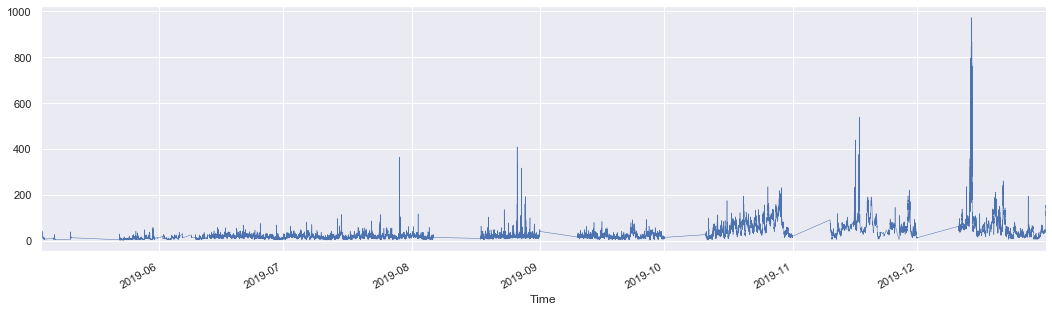

In [23]:
data_cleaned['SDS_P1'].plot(linewidth=0.5);

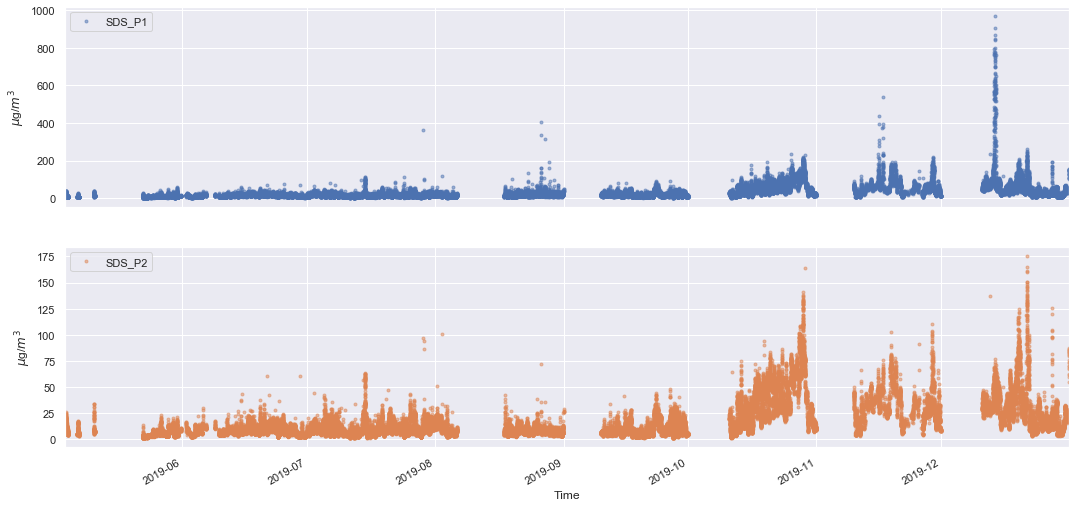

In [24]:
cols_plot = ['SDS_P1', 'SDS_P2']
axes = data_cleaned[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(18, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('$\mu$g/$m^3$')

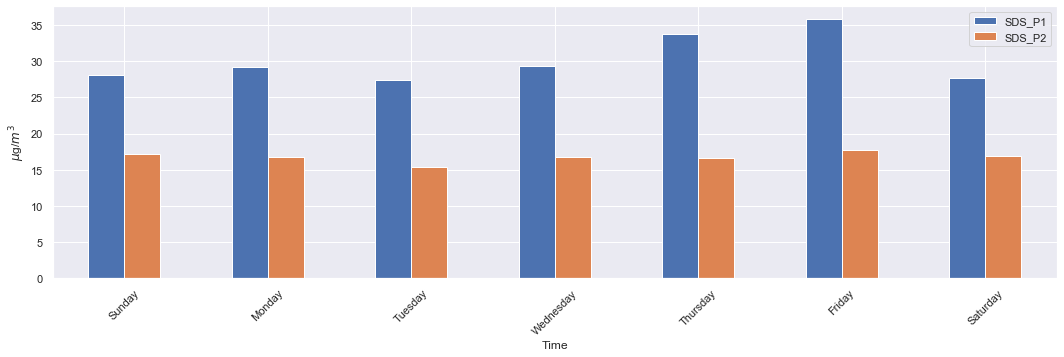

In [25]:
barchart = data_cleaned.groupby(data_cleaned.index.weekday)['SDS_P1','SDS_P2'].mean().plot(kind="bar")
barchart.set_xticklabels(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"],rotation=45);
barchart.set_ylabel('$\mu$g/$m^3$');

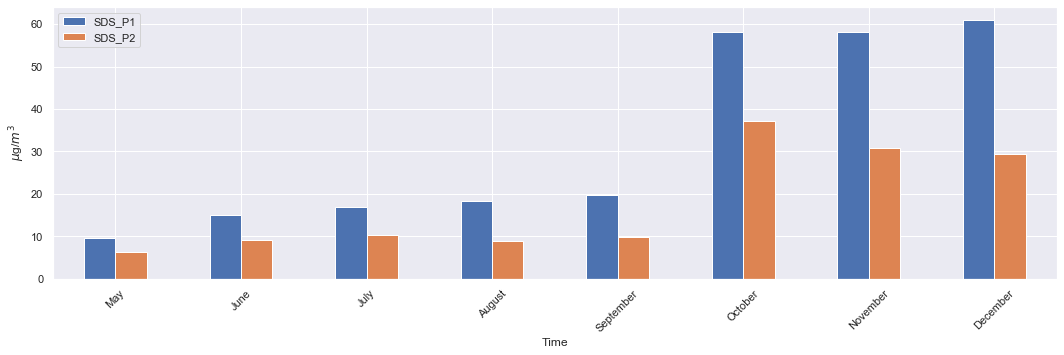

In [26]:
barchart = data_cleaned.groupby(data_cleaned.index.month)['SDS_P1','SDS_P2'].mean().plot(kind="bar")
barchart.set_xticklabels(["May","June","July","August","September","October","November","December"],rotation=45);
barchart.set_ylabel('$\mu$g/$m^3$');

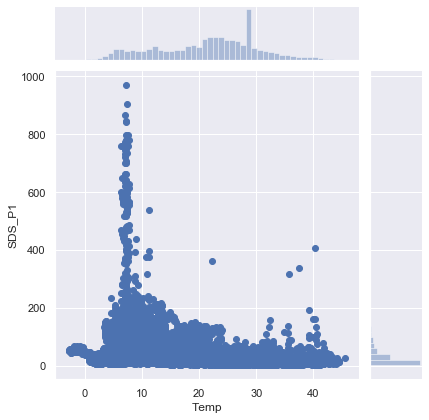

In [27]:
sns.jointplot(x='Temp',y='SDS_P1',data=data_cleaned)

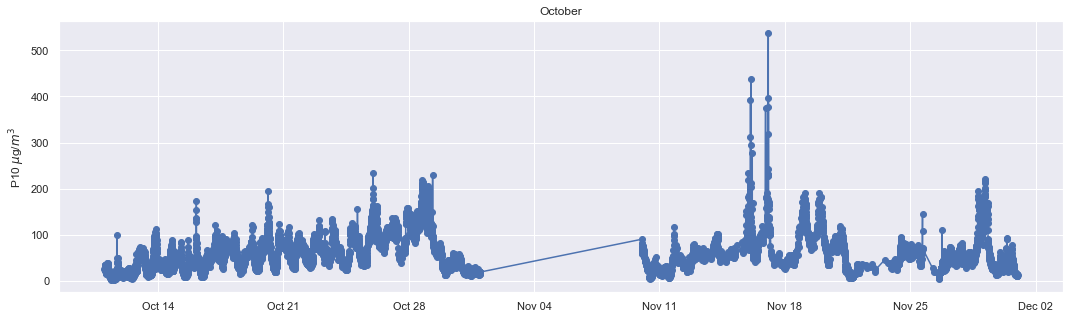

In [28]:
# matplotlib.dates for better viewing of dates

import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(data_cleaned.loc['2019-10':'2019-11', 'SDS_P1'], marker='o', linestyle='-')
ax.set_ylabel('P10 $\mu$g/$m^3$')
ax.set_title('October')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

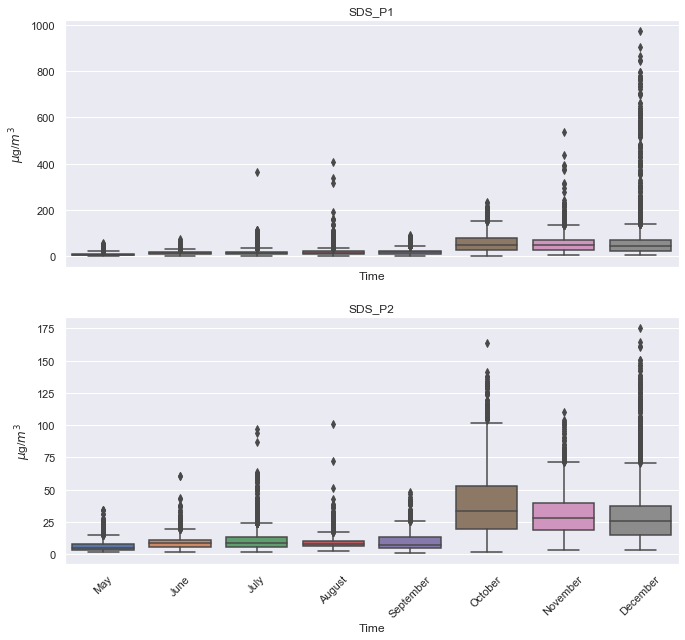

In [29]:
#seasonality using box-plot --> lots of outsiders

fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['SDS_P1', 'SDS_P2'], axes):
    sns.boxplot(data=data_cleaned, x=data_cleaned.index.month, y=name, ax=ax)
    ax.set_ylabel('$\mu$g/$m^3$')
    ax.set_title(name)
    ax.set_xticklabels(["May","June","July","August","September","October","November","December"],rotation=45);
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

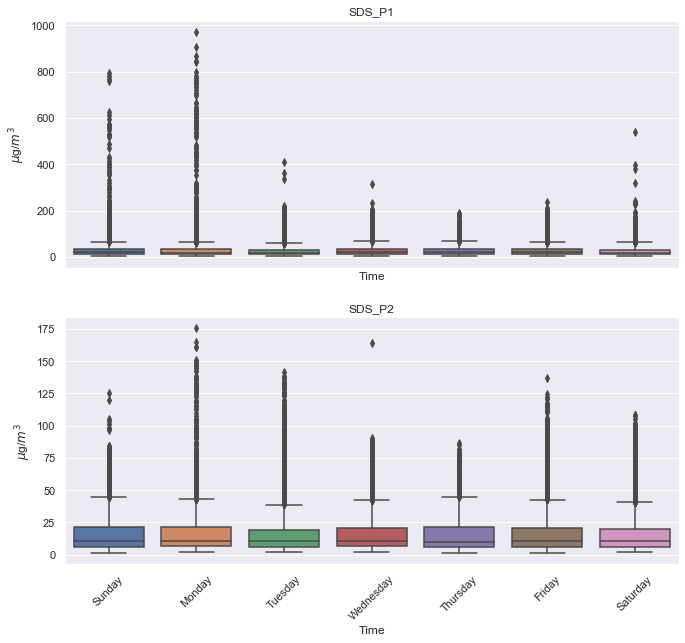

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['SDS_P1', 'SDS_P2'], axes):
    sns.boxplot(data=data_cleaned, x=data_cleaned.index.weekday_name, y=name, ax=ax)
    ax.set_ylabel('$\mu$g/$m^3$')
    ax.set_title(name)
    ax.set_xticklabels(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"],rotation=45);


### 3.1 Plotting data -  resampled data



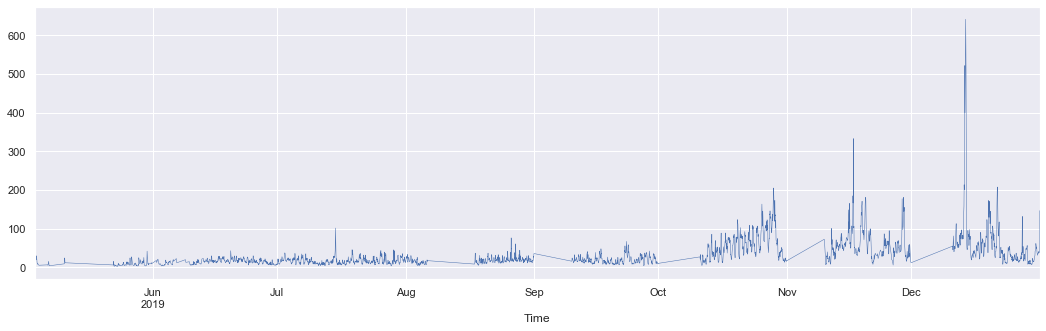

In [31]:
data_cleaned_resample['SDS_P1'].plot(linewidth=0.5);

We can compare the two data sets and see the plots on the same graph. The resampled data took care of some outsiders because of the mean method it used when it resampled.

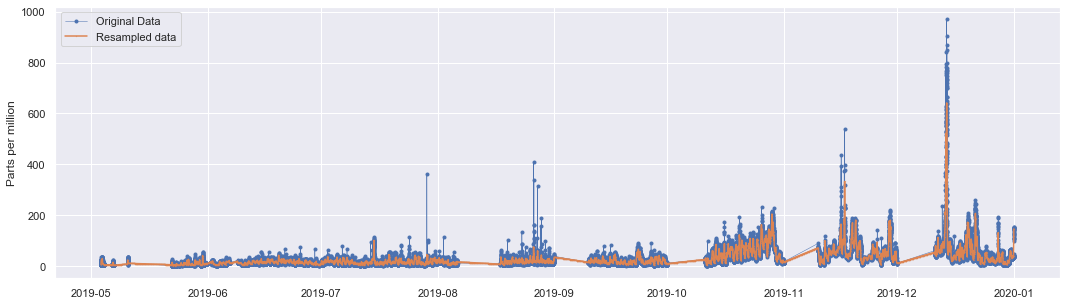

In [32]:
fig, ax = plt.subplots()
ax.plot(data_cleaned['SDS_P1'], marker='.', linestyle='-', linewidth=0.5, label='Original Data')
ax.plot(data_cleaned_resample['SDS_P1'], marker='.', markersize=0.5, linestyle='-', label='Resampled data')
ax.set_ylabel('Parts per million')
ax.legend();

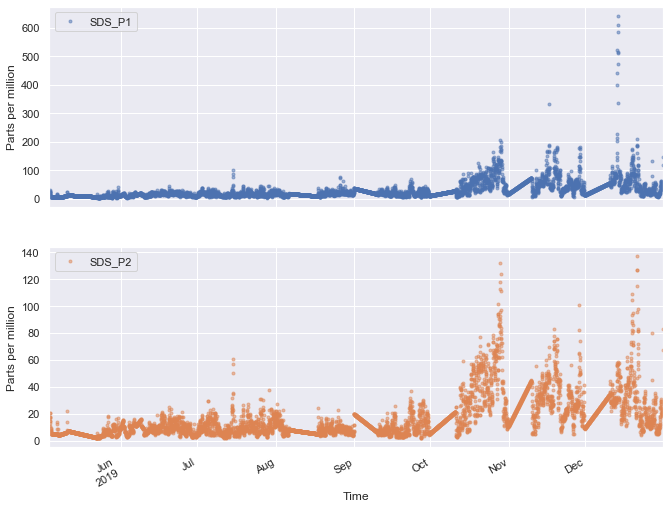

In [33]:
cols_plot = ['SDS_P1', 'SDS_P2']
axes = data_cleaned_resample[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Parts per million')

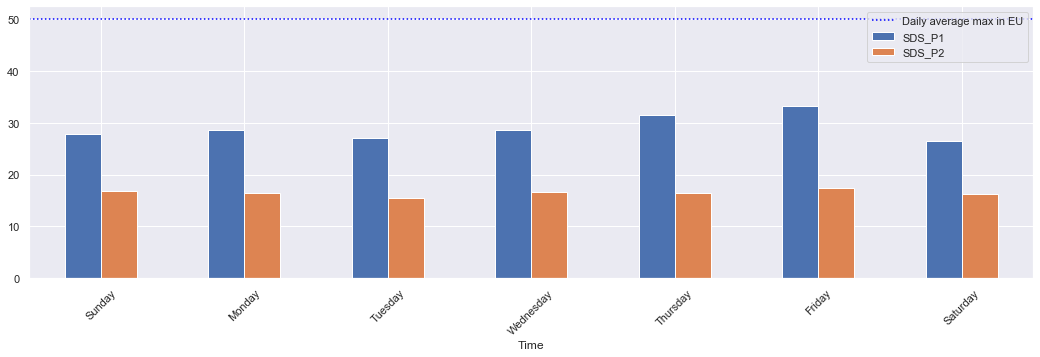

In [34]:
barchart = data_cleaned_resample.groupby(data_cleaned_resample.index.weekday)['SDS_P1','SDS_P2'].mean().plot(kind="bar")
barchart.set_xticklabels(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"],rotation=45);
#barchart.hlines(50,xmin=-1, xmax =7 , colors="blue", linestyles= 'dotted',label= "Daily average max in EU")
barchart.axhline(50,c="blue",linestyle=':',label= "Daily average max in EU")
barchart.legend(loc="best")

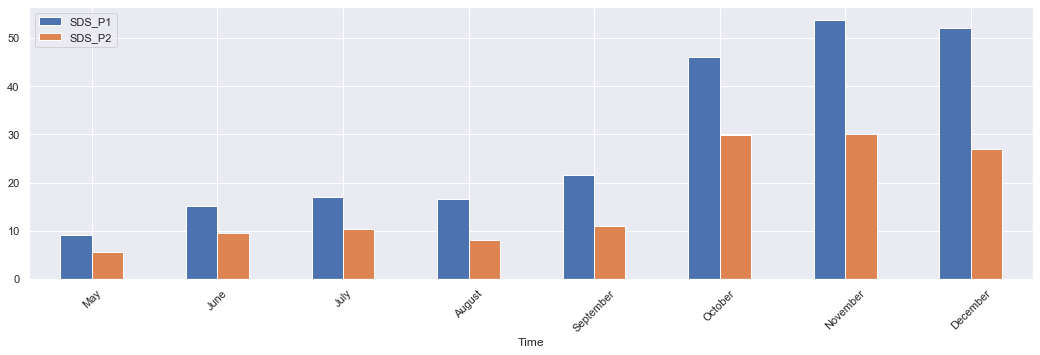

In [35]:
barchart = data_cleaned_resample.groupby(data_cleaned_resample.index.month)['SDS_P1','SDS_P2'].mean().plot(kind="bar")
barchart.set_xticklabels(["May","June","July","August","September","October","November","December"],rotation=45);

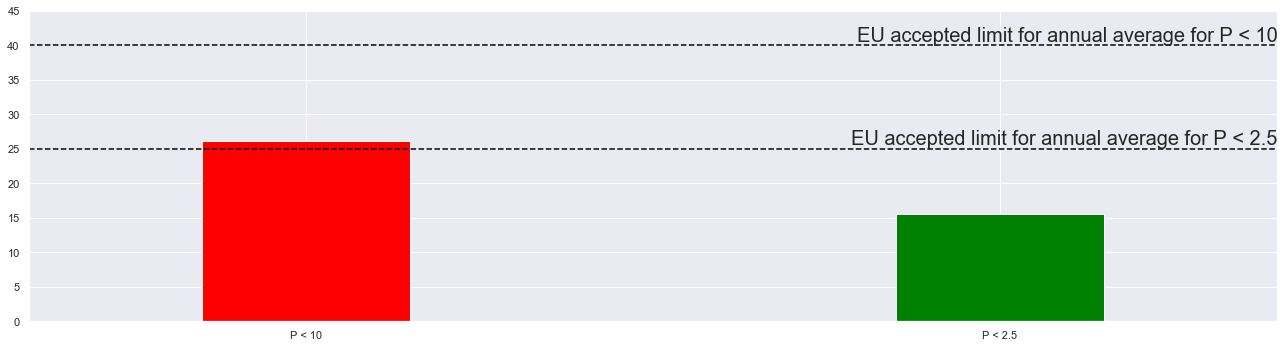

In [121]:
barchart = data_cleaned_resample[['SDS_P1','SDS_P2']].mean().plot(kind="bar",color=['red','green'],width = 0.3)
barchart.set_xticklabels(["P < 10", "P < 2.5"],rotation=0)
barchart.axhline(25, color = "black", linestyle="dashed")
barchart.axhline(40, color = "black", linestyle="dashed")
barchart.annotate('EU accepted limit for annual average for P < 2.5',
            xy=(1.4, 25),
            horizontalalignment='right',size=20,
            verticalalignment='bottom')
barchart.annotate('EU accepted limit for annual average for P < 10',
            xy=(1.4, 40),
            horizontalalignment='right',size=20,
            verticalalignment='bottom')
barchart.set_ylim(0,45)
plt.tight_layout()

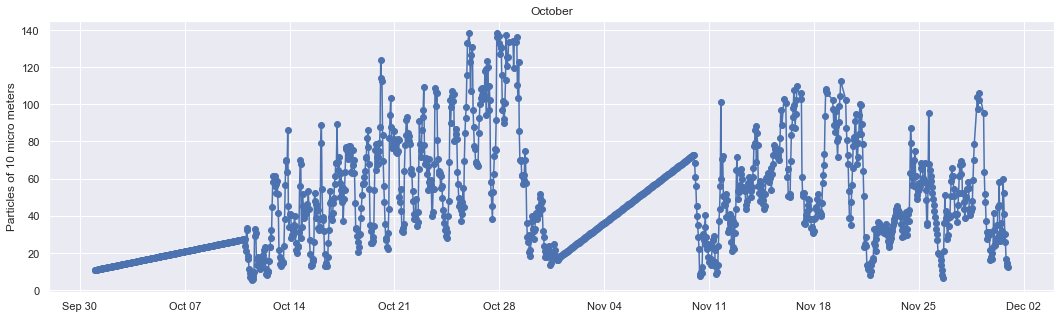

In [109]:


fig, ax = plt.subplots()
ax.plot(data_cleaned_resample.loc['2019-10':'2019-11', 'SDS_P1'], marker='o', linestyle='-')
ax.set_ylabel('Particles of 10 micro meters')
ax.set_title('October')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

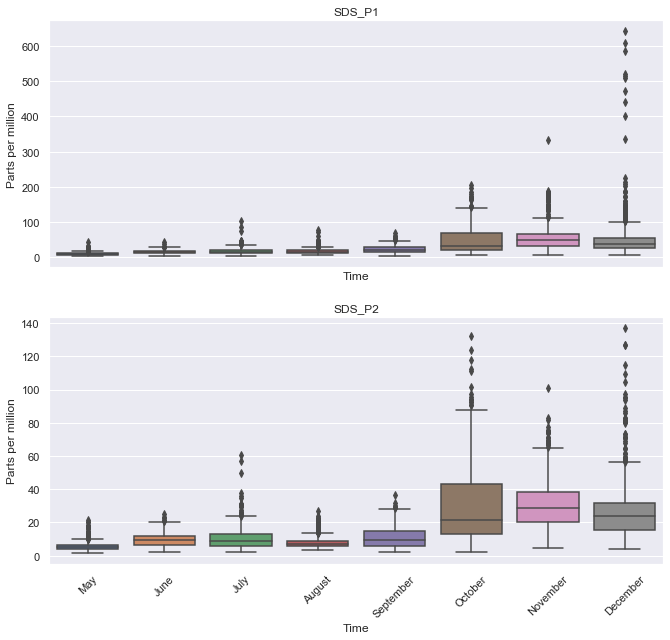

In [38]:
#seasonality using box-plot --> less outsiders in resmapled data!

fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['SDS_P1', 'SDS_P2'], axes):
    sns.boxplot(data=data_cleaned_resample, x=data_cleaned_resample.index.month, y=name, ax=ax)
    ax.set_ylabel('Parts per million')
    ax.set_title(name)
    ax.set_xticklabels(["May","June","July","August","September","October","November","December"],rotation=45);
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

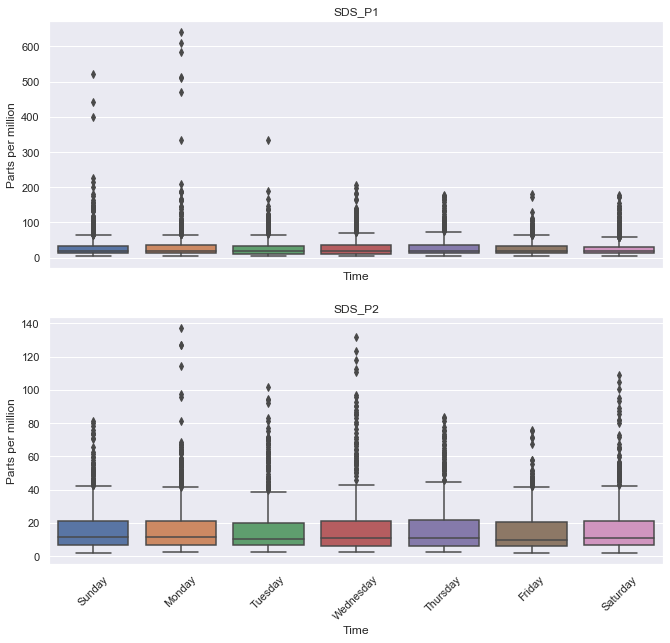

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['SDS_P1', 'SDS_P2'], axes):
    sns.boxplot(data=data_cleaned_resample, x=data_cleaned_resample.index.weekday_name, y=name, ax=ax)
    ax.set_ylabel('Parts per million')
    ax.set_title(name)
    ax.set_xticklabels(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"],rotation=45);

### 4. Wind Powered Energy Correlation

In [40]:
#read excel
wp = pd.read_excel('Grafic_SEN.xlsx',parse_dates=['Data'])

In [41]:
wp.head()

,Data,Consum[MW],Medie Consum[MW],Productie[MW],Carbune[MW],Hidrocarburi[MW],Ape[MW],Nuclear[MW],Eolian[MW],Foto[MW],Biomasa[MW],Sold[MW]
0,2019-12-31 22:50:41,6684,6766.0,6915,1316,1075,1372,1424,1671,0,57,-231
1,2019-12-31 22:40:51,6720,6766.0,6954,1298,1071,1348,1429,1751,0,58,-235
2,2019-12-31 22:31:01,6775,6766.0,7029,1289,1071,1320,1426,1865,0,58,-254
3,2019-12-31 22:21:11,6801,6766.0,7066,1286,1070,1312,1426,1915,0,57,-265
4,2019-12-31 22:11:21,6830,6766.0,7102,1295,1064,1301,1427,1958,0,57,-272


In [42]:
#select just windpower
wp_solo = wp[['Data','Eolian[MW]']]

In [43]:
wp_solo = wp_solo.set_index(['Data']).sort_index()

In [44]:
wp_solo.head()

,Eolian[MW]
Data,
2019-01-06 00:08:26,845
2019-01-06 00:18:16,799
2019-01-06 00:28:06,782
2019-01-06 00:37:56,799
2019-01-06 00:47:46,891


In [45]:
#column is not numeric
wp_solo['Eolian[MW]'].dtypes

dtype('O')

In [46]:
#identify the rows with the non-numeric values (NB - find out the meaning of "~" character)
wp_solo[~wp_solo.applymap(np.isreal).all(1)]

,Eolian[MW]
Data,
2019-09-10 06:11:30,2299*
2019-12-17 09:10:33,459*
2019-12-17 10:34:53,459*


In [47]:
#error selecting multiple time-indexes ?
#wp_solo.loc[['2019-12-17 10:34:53','2019-12-17 09:10:33']]

In [48]:
#same error dropping multiple time-indexes ?
#wp_solo.drop(['2019-12-17 10:34:53','2019-12-17 09:10:33','2019-09-10 06:11:30'],inplace=True)

In [49]:
wp_solo.loc['2019-12-17 10:34:53'] = 459
wp_solo.loc['2019-12-17 09:10:33'] = 459
wp_solo.loc['2019-09-10 06:11:30'] = 2299

In [50]:
wp_solo['Eolian[MW]'] = wp_solo['Eolian[MW]'].astype(float)

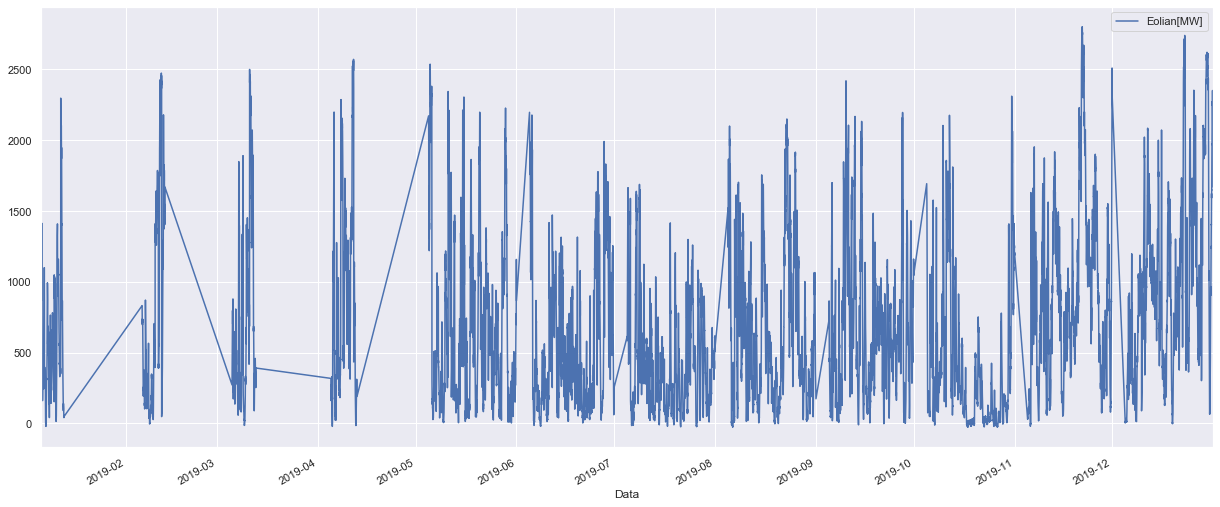

In [51]:
wp_solo.plot(figsize=(21,9));

In [52]:
wp_solo_resample = wp_solo.resample('H').mean()

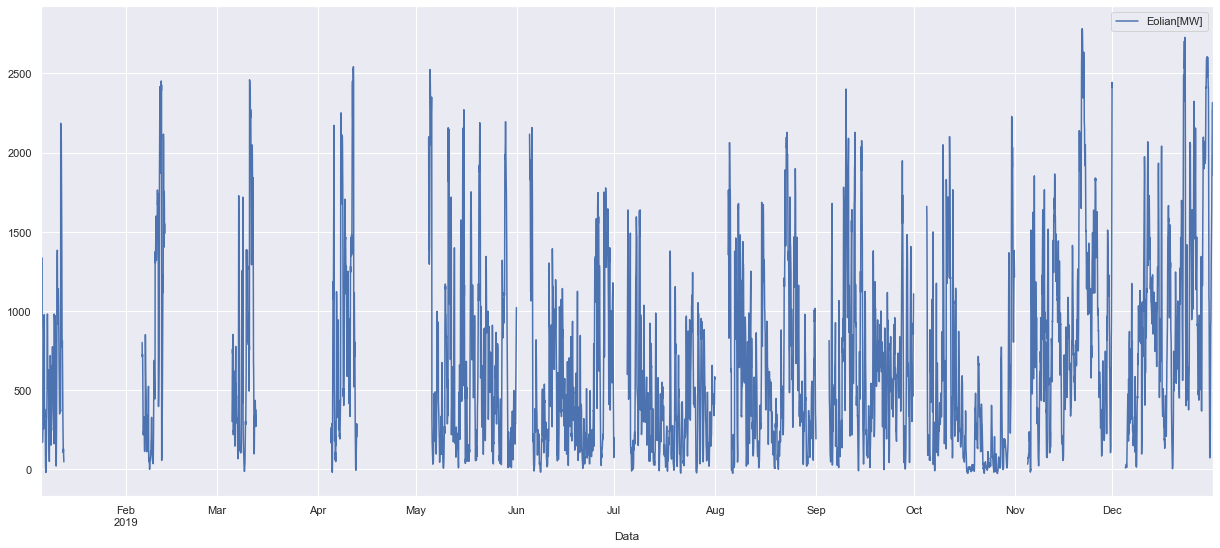

In [53]:
wp_solo_resample.plot(figsize=(21,9));

In [54]:
wp_solo_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8639 entries, 2019-01-06 00:00:00 to 2019-12-31 22:00:00
Data columns (total 1 columns):
Eolian[MW]    5816 non-null float64
dtypes: float64(1)
memory usage: 135.0 KB


In [55]:
wp_solo_resample.head()

,Eolian[MW]
Data,
2019-01-06 00:00:00,840.333333
2019-01-06 01:00:00,878.666667
2019-01-06 02:00:00,936.833333
2019-01-06 03:00:00,1106.500000
2019-01-06 04:00:00,1188.833333


In [56]:
# to plot them on the same graph seems like a bad idea, Y axis is way off, maybe just merge data sets first

In [57]:
combined = pd.merge(left = data_cleaned_resample, right = wp_solo_resample, left_index = True,right_index=True)

In [58]:
combined.head()

,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal,Eolian[MW]
2019-05-03 15:00:00,7.242857,5.610000,26.828571,61.414286,1.838832e+06,77.142857,24854.000000,-56.714286,NaN
2019-05-03 16:00:00,8.089167,5.584167,26.828571,61.414286,1.858361e+06,76.583333,38059.083333,-59.041667,NaN
2019-05-03 17:00:00,19.282632,10.978947,26.828571,61.414286,1.835992e+06,76.578947,43575.105263,-55.526316,NaN
2019-05-03 18:00:00,22.072381,17.670476,26.828571,61.414286,1.852807e+06,76.761905,47277.571429,-56.523810,NaN
2019-05-03 19:00:00,26.118261,20.264348,26.828571,61.414286,1.782423e+06,79.956522,48240.913043,-55.000000,NaN


In [59]:
combined['Eolian[MW]'] = combined['Eolian[MW]'].interpolate(method='time')

In [60]:
combined['Eolian[MW]'].isnull().sum()

33

In [61]:
#still some missing values, let's fill them up
combined['Eolian[MW]'].fillna(method='bfill',inplace=True)

In [62]:
combined['Eolian[MW]'].isnull().sum()

0

In [63]:
combined = combined.rename(columns={"Eolian[MW]": "Eolian"});

In [64]:
combined.head()

,SDS_P1,SDS_P2,Temp,Humidity,Samples,Min_cycle,Max_cycle,Signal,Eolian
2019-05-03 15:00:00,7.242857,5.610000,26.828571,61.414286,1.838832e+06,77.142857,24854.000000,-56.714286,2099.333333
2019-05-03 16:00:00,8.089167,5.584167,26.828571,61.414286,1.858361e+06,76.583333,38059.083333,-59.041667,2099.333333
2019-05-03 17:00:00,19.282632,10.978947,26.828571,61.414286,1.835992e+06,76.578947,43575.105263,-55.526316,2099.333333
2019-05-03 18:00:00,22.072381,17.670476,26.828571,61.414286,1.852807e+06,76.761905,47277.571429,-56.523810,2099.333333
2019-05-03 19:00:00,26.118261,20.264348,26.828571,61.414286,1.782423e+06,79.956522,48240.913043,-55.000000,2099.333333


In [65]:
# sns.pairplot(combined)  -> complex and computational-consuming 

In [66]:
combined_small = combined.loc[:,['SDS_P1','SDS_P2','Eolian']]

In [67]:
combined_small.head()

,SDS_P1,SDS_P2,Eolian
2019-05-03 15:00:00,7.242857,5.610000,2099.333333
2019-05-03 16:00:00,8.089167,5.584167,2099.333333
2019-05-03 17:00:00,19.282632,10.978947,2099.333333
2019-05-03 18:00:00,22.072381,17.670476,2099.333333
2019-05-03 19:00:00,26.118261,20.264348,2099.333333


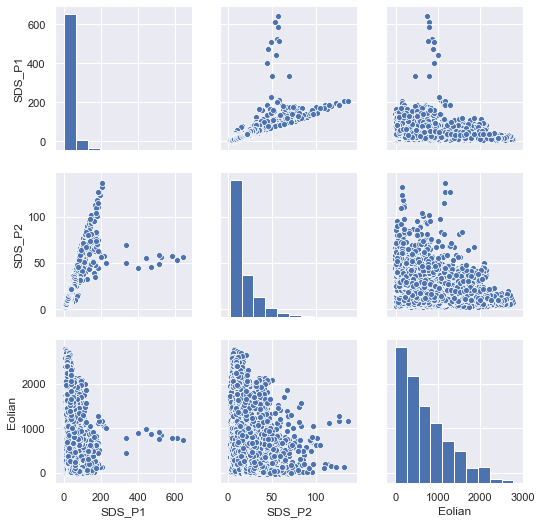

In [68]:
sns.pairplot(combined_small)

(3.0, 0.0)

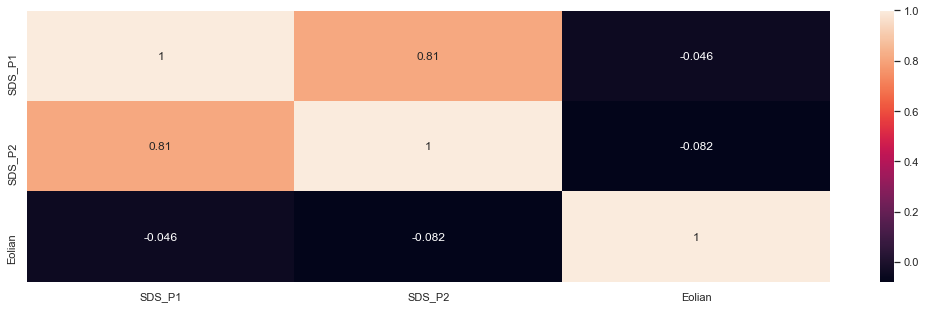

In [69]:
#workaround because of bug in matplotlib heatmap

ax = sns.heatmap(combined_small.corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

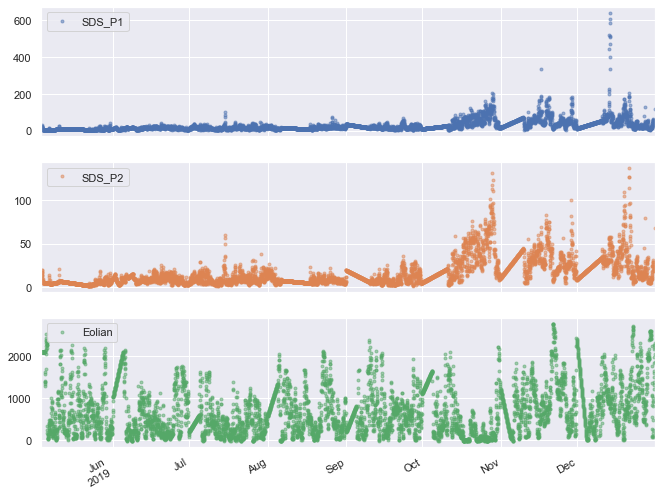

In [70]:
cols_plot = ['SDS_P1', 'SDS_P2','Eolian']
axes = combined_small[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)


### 5. Dropping outsiders

In [71]:
for m in range(5,13):
    median = np.median(data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m])
    upper_quartile = np.percentile(data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m], 75)
    lower_quartile = np.percentile(data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m], 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m][data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m]<=upper_quartile+1.5*iqr].max()
    lower_whisker = data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m][data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==m]>=lower_quartile-1.5*iqr].min()
    print("For {0} we have upper_quartile = {1:.2f},lower_quartile={2:.2f},iqr={3:.2f},upper_whisker={4:.2f} and lower_whisker={5:.2f}"
          .format(m,upper_quartile,lower_quartile,iqr,upper_whisker,lower_whisker))

For 5 we have upper_quartile = 10.44,lower_quartile=6.55,iqr=3.89,upper_whisker=16.07 and lower_whisker=2.94
For 6 we have upper_quartile = 18.52,lower_quartile=11.40,iqr=7.12,upper_whisker=29.13 and lower_whisker=3.93
For 7 we have upper_quartile = 20.96,lower_quartile=10.75,iqr=10.21,upper_whisker=35.81 and lower_whisker=3.98
For 8 we have upper_quartile = 18.96,lower_quartile=12.21,iqr=6.75,upper_whisker=28.95 and lower_whisker=4.94
For 9 we have upper_quartile = 27.81,lower_quartile=14.78,iqr=13.02,upper_whisker=45.53 and lower_whisker=4.56
For 10 we have upper_quartile = 67.40,lower_quartile=19.33,iqr=48.07,upper_whisker=138.44 and lower_whisker=5.39
For 11 we have upper_quartile = 64.75,lower_quartile=32.61,iqr=32.14,upper_whisker=112.62 and lower_whisker=6.22
For 12 we have upper_quartile = 55.34,lower_quartile=24.57,iqr=30.77,upper_whisker=98.93 and lower_whisker=7.24


Let's choose some round values above all whiskers and drop them, then re-analyze the data

In [72]:
for m,v in [(5,17),(6,30),(7,36),(8,30),(9,50),(10,140),(11,113),(12,100)]:
    data_cleaned_resample.drop(data_cleaned_resample[(data_cleaned_resample.index.month == m) & (data_cleaned_resample['SDS_P1'] > v)].index,inplace=True)

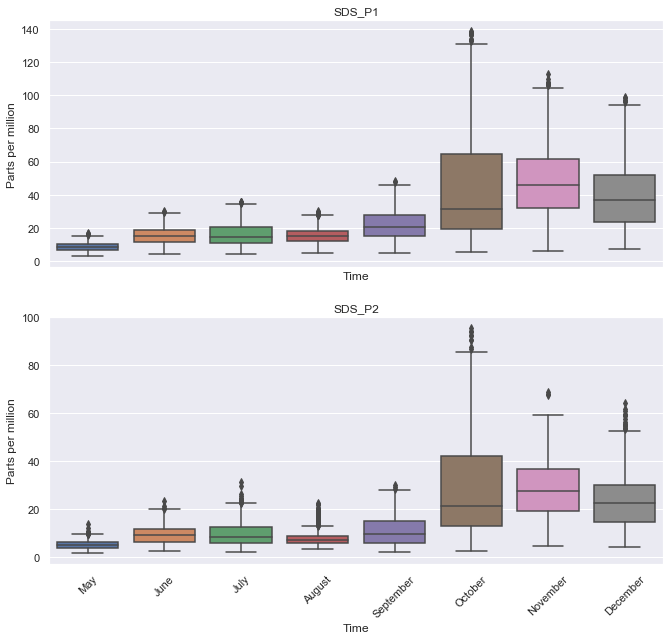

In [73]:
# re-do boxplot to see differences

fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['SDS_P1', 'SDS_P2'], axes):
    sns.boxplot(data=data_cleaned_resample, x=data_cleaned_resample.index.month, y=name, ax=ax)
    ax.set_ylabel('Parts per million')
    ax.set_title(name)
    ax.set_xticklabels(["May","June","July","August","September","October","November","December"],rotation=45);
# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

In [76]:
# another way to calculate value at percentile

# import scipy.stats
# scipy.stats.scoreatpercentile(data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==5],50)


In [79]:
import scipy.stats

scipy.stats.percentileofscore(data_cleaned_resample['SDS_P1'][data_cleaned_resample.index.month==12],90)

97.68451519536903

In [80]:
#97% of values fall between 90 on December